[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/events/2020_11_18_catboost_tutorial/mvs_and_uncertainty.ipynb)

In this tutorial we will use [Epsilon](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) dataset and part of [MSRank](https://www.microsoft.com/en-us/research/project/mslr/) dataset.

In [1]:
# # For Google Colaboratory:
# !pip install catboost

# # For your machine:
# !pip3 install --user -U ipywidgets catboost
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
import numpy as np
np.set_printoptions(precision=4)
import math
from catboost import Pool, CatBoostRegressor, CatBoost, MetricVisualizer, CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import catboost
print(catboost.__version__)

0.24.2


## Reading the data

In [4]:
from catboost.datasets import epsilon

(train_df, test_df) = epsilon()

In [5]:
train_df.shape

(400000, 2001)

In [6]:
X_train, y_train =  train_df.iloc[:,1:], train_df[0]
X_test, y_test = test_df.iloc[:,1:], test_df[0]
epsilon_train = Pool(X_train, y_train)
epsilon_test = Pool(X_test, y_test)

In [7]:
epsilon_train.quantize()
epsilon_test.quantize()

In [8]:
# epsilon_train.save('epsilon_train.quantized')
# epsilon_test.save('epsilon_test.quantized')

In [3]:
epsilon_train = Pool('quantized://epsilon_train.quantized')
epsilon_test = Pool('quantized://epsilon_test.quantized')

In [4]:
len(epsilon_train.get_label())

400000

## Bootstrap

The _bootstrap\_type_ parameter affects the following important aspects of choosing a split for a tree when building the tree structure <br>
-Regularization. To prevent overfitting, the weight of each training example is varied over steps of choosing different splits (not over scoring different candidates for one split) or different trees. <br>
-Speeding up.<br>
[documentation](https://catboost.ai/docs/concepts/algorithm-main-stages_bootstrap-options.html?lang=en)

- __No__ <br> 

- __Bernoulli__ <br> 
Associated parameters: $s$=_subsample, sampling\_unit_  <br>
Realization of Stochastic Gradient Boosting (SGB).
For each iteration of the boosting process, the sampling algorithm of SGB selects random $s\cdot N$ objects without replacement and uniformly, i. e. every document sampled with probability $p \sim Bernoulli(s)$). <br>
$E(\text{sampled size}) = \sum 1 \cdot P_{\text{document in subsample}} =   s \cdot N$ <br>
It effectively reduces the complexity of each iteration down to the factor of $s$.

Associated parameter _sampling\_unit_ set the sampling scheme and has sense only with groups in pool.
Possible values:
Object — The weight of the i-th object is used for sampling the corresponding object.
Group — The weight of the group is used for sampling each object from the group. <br>

- __Poisson__ (GPU only) <br> 
Associated parameters: _subsample, sampling\_unit_ <br> 

$w = \psi$, $\psi \sim Poisson \left(\log(1 - subsample)\right)$<br> 
$$P(\psi = k) = \frac{e^{-\lambda}\lambda^k}{k!}$$
Poisson is a discrete probability distribution, so consider it like taken document in subsample $\psi$ time. <br>
 If subsample is equal to 0.66, this approximates the classical bootstrap (sampling  examples with repetitions).

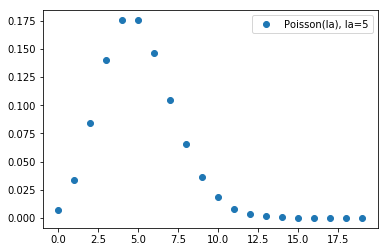

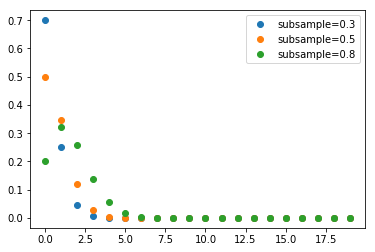

In [5]:
from scipy.special import factorial

la = 5
k = np.arange(0, 20, 1)
w = np.exp(-la)  * np.power(la, k) / factorial(k)


plt.plot( k, w , 'o', label="Poisson(la), la={}".format(la))
plt.legend()
plt.show()

for subsample in (0.3, 0.5, 0.8):
    la = -np.log(1-subsample)
    w = np.exp(-la)  * np.power(la, k) / factorial(k)
    plt.plot(k, w, 'o', label="subsample={}".format(subsample))
plt.legend()
plt.show()

- __Bayesian bootstrap__ <br> 
Associated parameters: _sampling\_unit, $t$=_bagging\_temperature_ <br> 
The Bayesian bootstrap generate random weights for each document independently.
This bootstrap type serves only for the regularization, not for speeding up.<br> 
$w = a^t$, $a = -log(\psi)$,  $\psi \sim Uniform[0, 1]$.

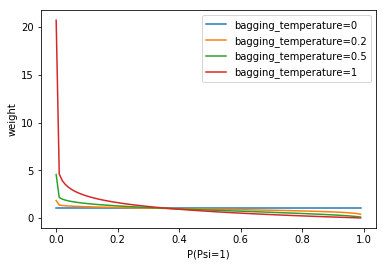

In [7]:
t = np.arange(0.0 + 1e-9, 1.0, 0.01)
s = -np.log(t)

fig, ax = plt.subplots()
for temp in (0, 0.2, 0.5, 1):
    ax.plot(t, np.power(s, temp), label="bagging_temperature={}".format(temp))

ax.set(xlabel='P(Psi=1)', ylabel='weight')
plt.legend()

plt.show()


- __MVS__ <br> 
Associated parameters: _mvs\_reg, s=subsample_<br> 

$$g_i = \left.\frac{\partial L(y_i, z)}{\partial z} \right|_{z=M_i}$$
where $L$ is the loss function, $y_i$ is the target of the example and $M_i$ is the current model prediction for the example  <br> 

1. Select threshold $t$ such that
$\sum_{|g_i| \ge t} 1 + \sum_{|g_i| < t} \frac{|g_i|} {t} = s \cdot N$
2. Every document sampled with probability $p = 1$  if $|g_i| \ge t$ or  $p = \frac{|g_i|} {t}$ otherwise. 
<br>

(!) regularization:
$$|g| \to \sqrt{g^2 + \lambda}$$
where $\lambda=$  _mvs\_reg,_ if _mvs\_reg_ is set. Otherwise $\lambda = $ L1 sum of gradients on the first iteration and L1 sum of leafweights on latest iterations.

## Example

In [12]:
import json
import timeit

default_parameters = {
    'iterations': 1000,
    'loss_function': 'Logloss',
    'verbose': 250,
    'random_seed': 0,
    'task_type': 'GPU',
    'learning_rate': 0.3,
#     'devices': '0'
}

parameters = {}
def fit_model(additional_params=None, train_pool=epsilon_train, test_pool=epsilon_test):
    parameters = deepcopy(default_parameters)
    parameters['train_dir'] = default_parameters['loss_function']
    
    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=test_pool)
    statictics={
        'bootstrap_type': additional_params,
        'best_iteration': model.best_iteration_,
        'best_score_validation':  model.best_score_['validation']
    }
    print(json.dumps(statictics))
    with open('statistics', "a") as out:
        out.write(json.dumps(statictics))
    return model

In [13]:
for bootstrap_type in [
#     {'bootstrap_type': 'No', "iterations": 1000},
    {'bootstrap_type': 'Bayesian', "iterations": 1000},
#     {'bootstrap_type': 'Poisson', "iterations": 1000},
    {'bootstrap_type': 'Poisson', "iterations": 1000, 'subsample': 0.5},
#     {'bootstrap_type': 'Bernoulli', "iterations": 1000, 'subsample': 0.4},
#     {'bootstrap_type': 'MVS', 'subsample': 0.5, 'task_type': 'CPU', "iterations": 1000},
    {'bootstrap_type': 'MVS', 'subsample': 0.2, 'task_type': 'CPU', "iterations": 1000, 'learning_rate': 0.2},
    ]:
    training_time = timeit.timeit('fit_model({})'.format(json.dumps(bootstrap_type)),
                         setup="from __main__ import fit_model", 
                         number=1)
    with open('statistics', "a") as out:
        out.write(', {}s\n'.format(training_time))
    print('time', training_time, '\n')

0:	learn: 0.6475378	test: 0.6486123	best: 0.6486123 (0)	total: 238ms	remaining: 3m 58s
250:	learn: 0.2740497	test: 0.2910567	best: 0.2910567 (250)	total: 49.2s	remaining: 2m 26s
500:	learn: 0.2442583	test: 0.2761285	best: 0.2761285 (500)	total: 1m 35s	remaining: 1m 34s
750:	learn: 0.2260054	test: 0.2724364	best: 0.2724364 (750)	total: 2m 18s	remaining: 46s
999:	learn: 0.2109588	test: 0.2714410	best: 0.2714189 (980)	total: 3m 2s	remaining: 0us
bestTest = 0.2714188672
bestIteration = 980
Shrink model to first 981 iterations.
{"bootstrap_type": {"bootstrap_type": "Bayesian", "iterations": 1000}, "best_iteration": 980, "best_score_validation": {"Logloss": 0.2714188671875}}
time 190.77030213399848 

0:	learn: 0.6472223	test: 0.6482803	best: 0.6482803 (0)	total: 174ms	remaining: 2m 54s
250:	learn: 0.2753794	test: 0.2915541	best: 0.2915541 (250)	total: 38s	remaining: 1m 53s
500:	learn: 0.2458325	test: 0.2762913	best: 0.2762913 (500)	total: 1m 14s	remaining: 1m 14s
750:	learn: 0.2273381	test: 

example of output for 

In [30]:
#     {'bootstrap_type': 'No', "iterations": 1000},
    {'bootstrap_type': 'Bayesian', "iterations": 1000},
#     {'bootstrap_type': 'Poisson', "iterations": 1000},
    {'bootstrap_type': 'Poisson', "iterations": 1000, 'subsample': 0.5},
#     {'bootstrap_type': 'Bernoulli', "iterations": 1000, 'subsample': 0.4},
#     {'bootstrap_type': 'MVS', 'subsample': 0.5, 'task_type': 'CPU', "iterations": 1000},
    {'bootstrap_type': 'MVS', 'subsample': 0.2, 'task_type': 'CPU', "iterations": 2000, 'learning_rate': 0.2},

({'bootstrap_type': 'MVS',
  'iterations': 2000,
  'learning_rate': 0.2,
  'subsample': 0.2,
  'task_type': 'CPU'},)

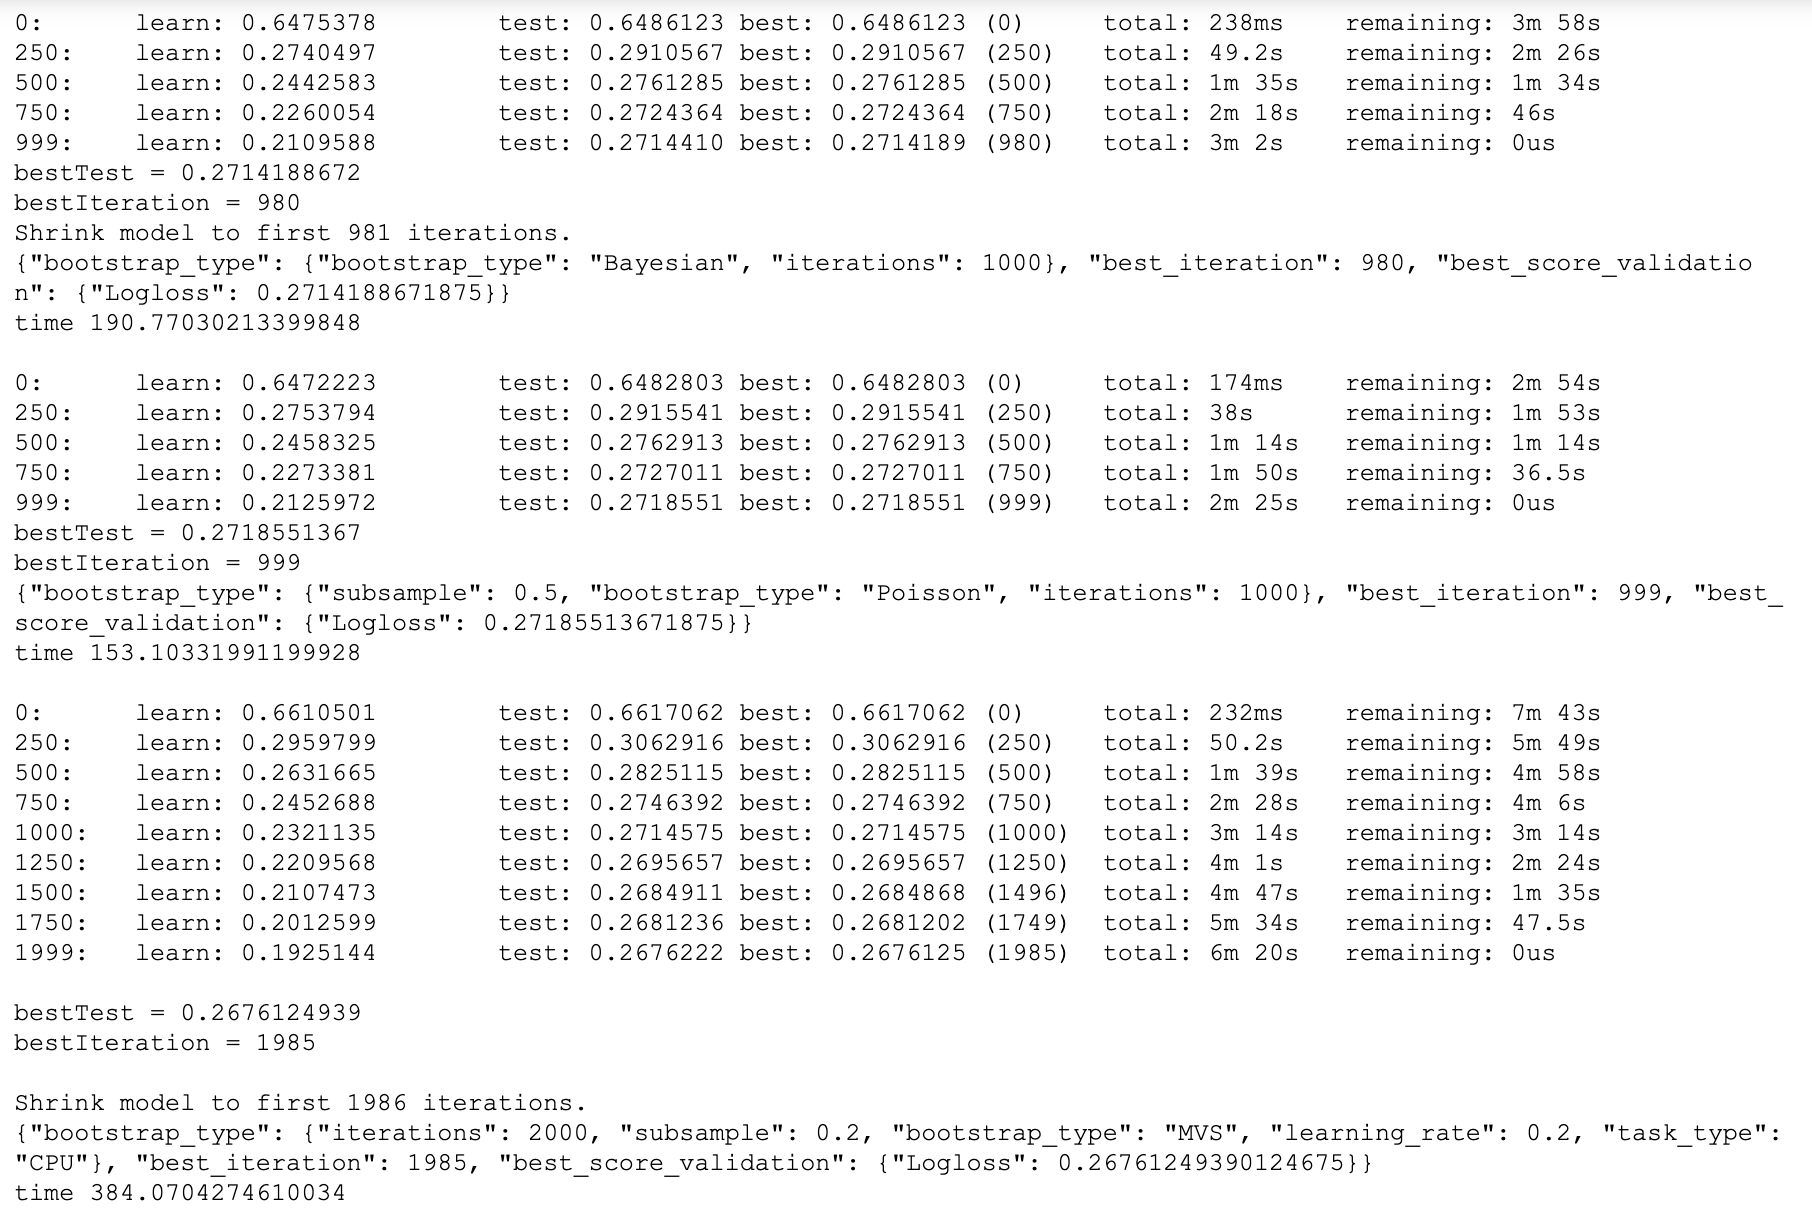

# Uncertainty in CatBoost


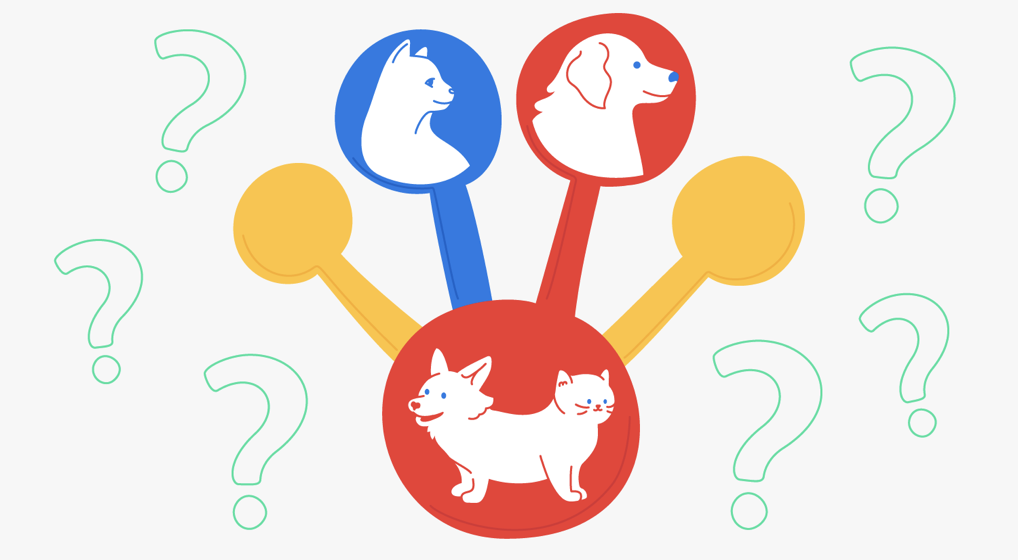

Loss function __RMSEWithUncertainty__ estimates parameters $\mu$, $\sigma$ of the normal distribution:
$$p(t\vert a) =  N(y \vert a_0, e^{2a_1}) = N(y \vert \mu, \sigma^2) = \frac{1}{2 \pi\sigma^2} \exp(-\frac{(y-\mu)^2}{2\sigma^2})$$
$$L = -\frac{1}{N} \sum \log p(t_i \vert a_i) =$$
$$= -\frac{1}{N} \sum_{i=1}^N \log(\frac{1}{2 \pi\sigma^2} \exp(-\frac{(y-\mu)^2}{2\sigma^2})) =
C +\frac{1}{N}\sum_{i=1}^N \left(a_{i,1} + \frac{1}{2} \exp(-2 a_{i,1} (t_i - a_{i, 0})^2) \right)$$

Generate pool: noisy artcg on interval $[-10, 10]$ with hole in $(1, 5)$, noise dispersion is periodic.

In [14]:
X = np.concatenate((
    np.arange(-10, 1, 0.0005, dtype=np.float32),
    np.arange(5, 10, 0.0005, dtype=np.float32))
)
Y = np.arctan(X)
for i in range(len(X)):
    Y[i] = np.random.normal(Y[i], np.sin(X[i]/1.5) ** 2 /2)


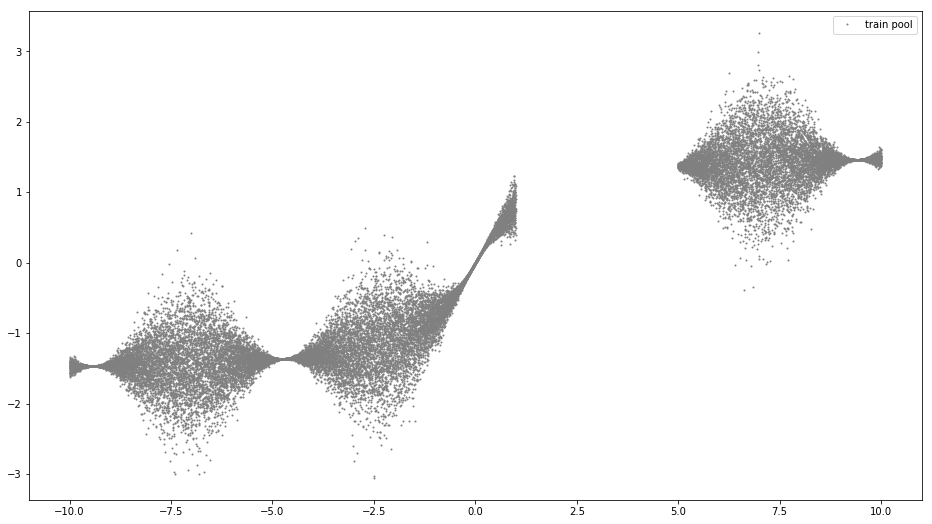

In [15]:
plt.figure(figsize = (16,9))
plt.plot(X, Y, '.', c='gray', markersize=2, label = 'train pool')
plt.legend()
plt.show()


Fit model with 
_loss_function='RMSEWithUncertainty'_ and _posterior_sampling=True_ 
on our pool <br>
Best value of RMSEWithUncertainty is minimal, it could look unusual (negative)

In [16]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSEWithUncertainty',
                          verbose=100, random_seed=0, border_count=1024, posterior_sampling=True)
Xs = X.reshape((len(X), 1))

model.fit(Xs, Y)

0:	learn: 1.0412314	total: 11.7ms	remaining: 11.7s
100:	learn: -1.1412396	total: 1.01s	remaining: 9s
200:	learn: -1.2410616	total: 2s	remaining: 7.96s
300:	learn: -1.2566394	total: 2.98s	remaining: 6.93s
400:	learn: -1.2625847	total: 3.97s	remaining: 5.93s
500:	learn: -1.2599869	total: 5.01s	remaining: 4.99s
600:	learn: -1.2765229	total: 5.99s	remaining: 3.97s
700:	learn: -1.2888141	total: 6.99s	remaining: 2.98s
800:	learn: -1.3024039	total: 7.98s	remaining: 1.98s
900:	learn: -1.2982001	total: 8.96s	remaining: 985ms
999:	learn: -1.3056657	total: 9.99s	remaining: 0us


In [17]:
validate = np.arange(-10, 10, 0.0005, dtype=np.float32)
Yv = np.arctan(validate)
Vs = validate.reshape((len(validate), 1))
vapred = model.virtual_ensembles_predict(Vs, prediction_type='TotalUncertainty', virtual_ensembles_count=5)
vapred.shape

(40000, 3)

TotalUncertainty for RMSEWithUncertainty returns ['mean_predict', 'data uncertainty', 'knowledge uncertainty']

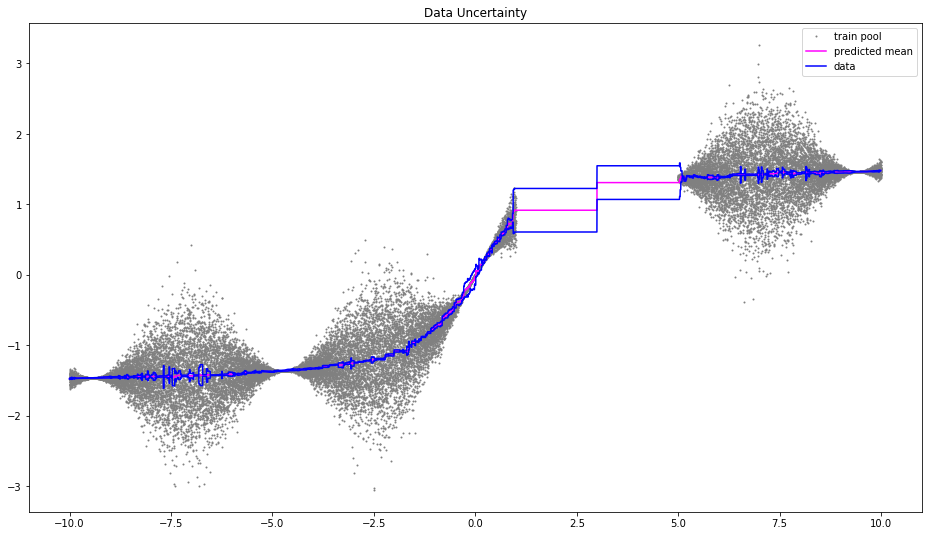

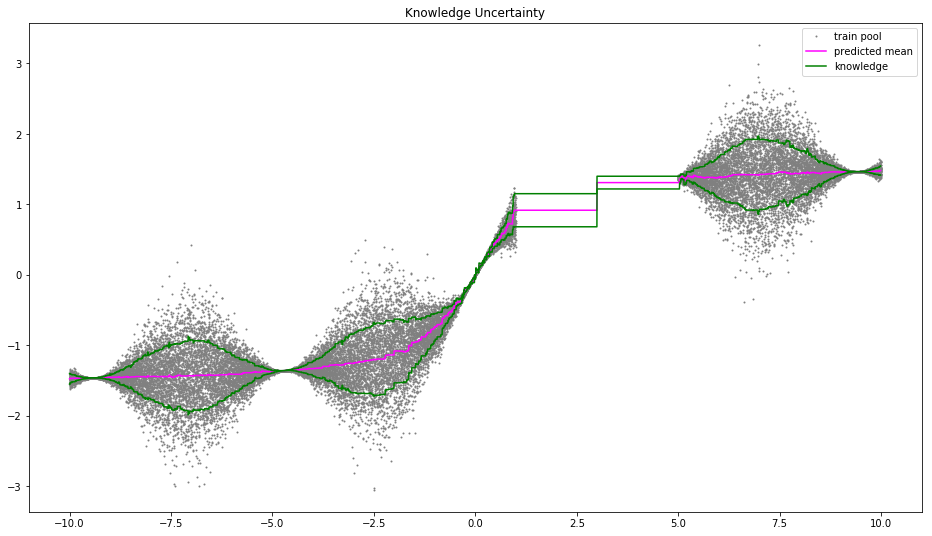

In [18]:
plt.figure(figsize = (16,9))
plt.plot(X, Y, '.', c='gray', markersize=2, label = 'train pool')
plt.plot(Vs, vapred[:, 0],c='magenta', label='predicted mean')
plt.plot(Vs, vapred[:, 0] + 20 * np.sqrt(vapred[:, 1] ), c='blue', label = 'data')
plt.plot(Vs, vapred[:, 0] - 20 * np.sqrt(vapred[:, 1] ), c='blue')
plt.title("Data Uncertainty")
plt.legend()
plt.show()

plt.figure(figsize = (16,9))
plt.plot(X, Y, '.', c='gray', markersize=2, label = 'train pool')
plt.plot(Vs, vapred[:, 0],c='magenta', label='predicted mean')
plt.plot(Vs, vapred[:, 0] + np.sqrt( vapred[:, 2]), c='green', label = 'knowledge')
plt.plot(Vs, vapred[:, 0] - np.sqrt( vapred[:, 2]), c='green')
plt.title("Knowledge Uncertainty")
plt.legend()
plt.show();

In [19]:
virtual_ensembles_count = 4
virtual_ensembles_predict = model.virtual_ensembles_predict(Vs, virtual_ensembles_count=virtual_ensembles_count)
virtual_ensembles_predict.shape

(40000, 4, 2)

[document_count, virtual_ensembles_count, approx_dimensio]

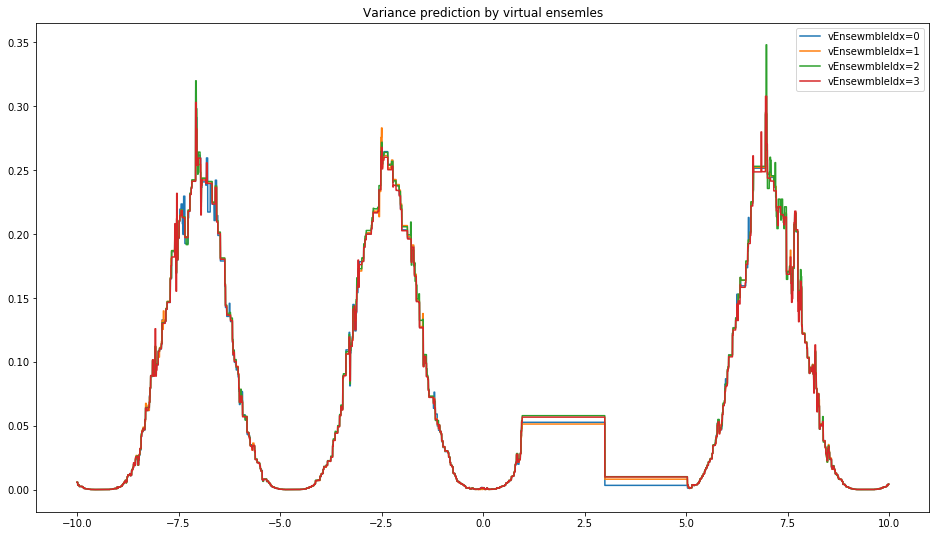

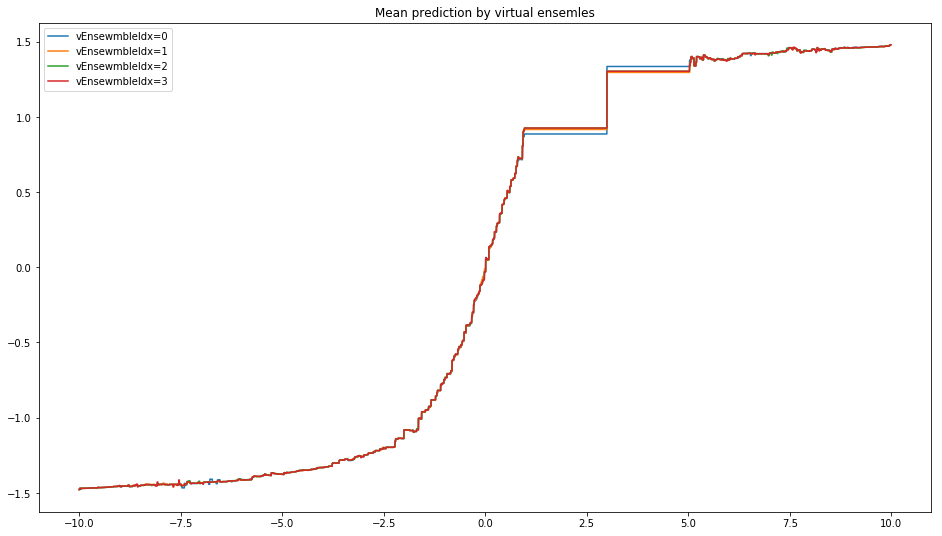

In [20]:
plt.figure(figsize = (16,9))
for idx in range(virtual_ensembles_count):
    plt.plot(Vs, virtual_ensembles_predict[:, idx, 1], label='vEnsewmbleIdx={}'.format(idx))
plt.title("Variance prediction by virtual ensemles")
plt.legend()
plt.show();

plt.figure(figsize = (16,9))
for idx in range(virtual_ensembles_count):
    plt.plot(Vs, virtual_ensembles_predict[:, idx, 0], label='vEnsewmbleIdx={}'.format(idx))
plt.title("Mean prediction by virtual ensemles")
plt.legend()
plt.show();

### Download part of [MSRank](https://www.microsoft.com/en-us/research/project/mslr/) dataset from CatBoost datasets storage

In [21]:
from catboost.datasets import msrank_10k

# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

train_df, test_df = msrank_10k()

We also create corrupted pool without documents with label = 2.

In [22]:
X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values

dropped_label = 2.

corrupted_train_df = train_df[train_df[0] != dropped_label] # !
X_train_corrupted = corrupted_train_df.drop([0, 1], axis=1).values
y_train_corrupted = corrupted_train_df[0].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values

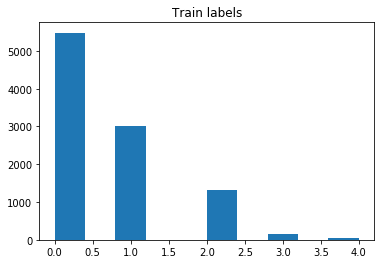

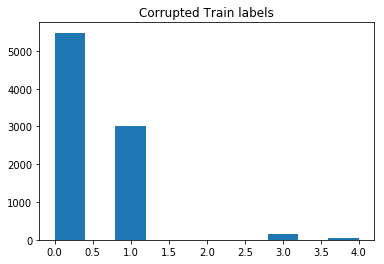

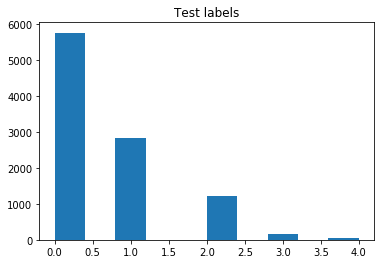

In [23]:
plt.hist(y_train)
plt.title("Train labels")
plt.show()
plt.hist(y_train_corrupted )
plt.title("Corrupted Train labels")
plt.show()
plt.hist(y_test)
plt.title("Test labels")
plt.show()

### Creation of CatBoost pools

In [24]:
train = Pool(
    data=X_train,
    label=y_train
)
corrupted_train = Pool(
    data=X_train_corrupted,
    label=y_train_corrupted
)


test = Pool(
    data=X_test,
    label=y_test
)

Learn to models

In [25]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.015, loss_function='RMSE',
                          posterior_sampling=True, verbose=False, random_seed=0)

model.fit(train, eval_set=test)
print("best iteration =", model.get_best_iteration())

best iteration = 853


In [26]:
corrupted_model = CatBoostRegressor(iterations=1000, learning_rate=0.015, loss_function='RMSE',
                          posterior_sampling=True, verbose=False, random_seed=0)

corrupted_model.fit(corrupted_train, eval_set=test)
print("best iteration =", model.get_best_iteration())

best iteration = 853


Calculate TotalUncertainty
for regression models learned without RMSEWithUncertainty loss function we still couls see data uncertainty, if posterior_sampling=True was used

In [27]:
uncertainty1 = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty') # virtual_ensembles_count=10
uncertainty2 = corrupted_model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty') # virtual_ensembles_count=10


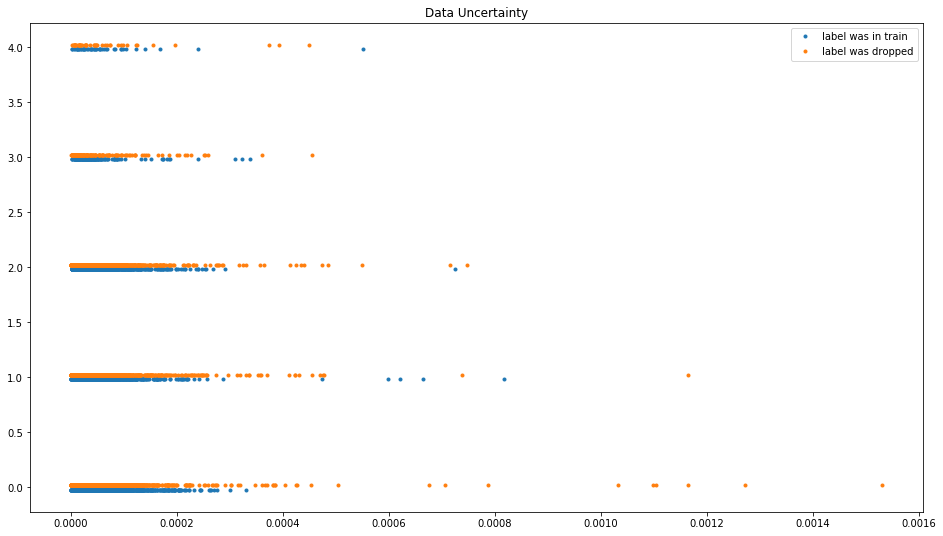

In [28]:
plt.figure(figsize = (16,9))
plt.plot(uncertainty1[:, 1],  test_df[0] - 0.02, '.', label = "label was in train")
plt.plot(uncertainty2[:, 1],  test_df[0]  + 0.02 , '.', label = "label was dropped")
plt.title('Data Uncertainty')
plt.legend()
plt.show()

Model according to RMSEWithUncertainty overfits very fast, so we recommend to use  eval_metric='RMSE'.

In [34]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.02, loss_function='RMSEWithUncertainty',
                          posterior_sampling=True, custom_metric='RMSE', verbose=False, random_seed=0)

model.fit(train, eval_set=test)
print("best score=", model.best_score_)

best score= {'learn': {'RMSEWithUncertainty': 0.21346291236962478, 'RMSE': 0.6433434478404289}, 'validation': {'RMSEWithUncertainty': 0.552283932339321, 'RMSE': 0.7282579429264896}}


In [35]:
print("best iteration=", model.best_iteration_)

best iteration= 231


In [36]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.02, loss_function='RMSEWithUncertainty',
                          posterior_sampling=True, eval_metric='RMSE', verbose=False, random_seed=0)

model.fit(train, eval_set=test)
print("best score=", model.best_score_)
print("best iteration=", model.best_iteration_)

best score= {'learn': {'RMSEWithUncertainty': 0.21346291236962478, 'RMSE': 0.6433434478404289}, 'validation': {'RMSEWithUncertainty': 0.552283932339321, 'RMSE': 0.7282579429264896}}
best iteration= 729
